# 💹Prediction of Stock Returns with Recurrent Neural Network

## 🔧Preparing the tools

In [1]:
# Import all the tools

# Regular EDA (Exploratory Data Analysis) and plotting libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")

# Models from Tensorflow (Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

# # Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

# Datareader, datetime and math module
from pandas_datareader import data
import datetime
import math

## 📇Load Data

In [2]:
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime.today()

>**Let's analyze the data of `'Kotak Mahindra Bank'` for predicting the stock returns, as it shows the best growth over other banks.**

In [3]:
# Getting the dataset
kotak_df = data.DataReader("KOTAKBANK.NS", data_source='yahoo', start=start_date, end=end_date)

kotak_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-01,366.024994,360.375000,366.000000,361.274994,785536.0,359.863800
2014-01-02,365.725006,351.500000,361.299988,353.700012,912278.0,352.318420
2014-01-03,358.149994,348.299988,353.549988,356.274994,1145134.0,354.883362
2014-01-06,358.500000,352.799988,355.000000,357.049988,893430.0,355.655334
2014-01-07,357.500000,350.000000,356.000000,354.075012,1287588.0,352.691956


## 🔎Data Exploration

In [4]:
kotak_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1796 entries, 2014-01-01 to 2021-04-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1796 non-null   float64
 1   Low        1796 non-null   float64
 2   Open       1796 non-null   float64
 3   Close      1796 non-null   float64
 4   Volume     1796 non-null   float64
 5   Adj Close  1796 non-null   float64
dtypes: float64(6)
memory usage: 98.2 KB


In [5]:
# Get the number of rows and columns in the data set
kotak_df.shape

(1796, 6)

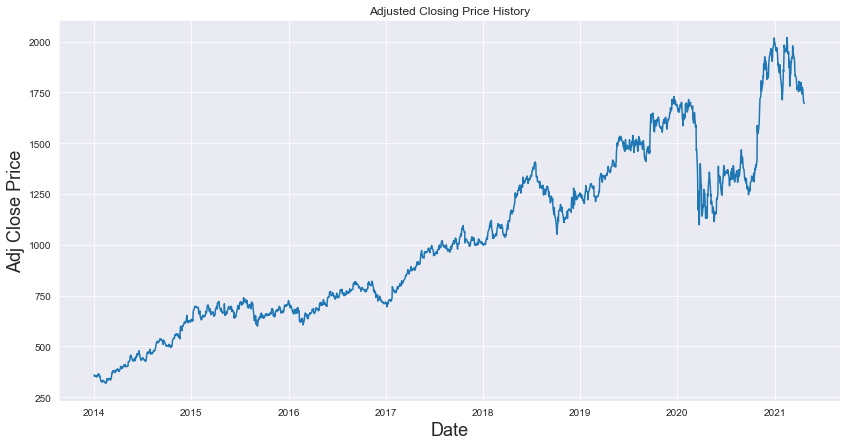

In [6]:
# Visualize the Adjusted Closing Price (Adj Close) history
plt.figure(figsize=(14, 7))
plt.plot(kotak_df["Adj Close"])
plt.title("Adjusted Closing Price History")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Adj Close Price", fontsize=18);

## 🎨Getting Data Ready

In [7]:
# Create a new dataframe with only the "Adj Close" column and convert it into a numpy array
dataset = kotak_df.filter(["Adj Close"]).values

In [8]:
# Get the number of rows to train the model on (80 percent of the whole dataset)
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

1437

### Feature Scaling

In [9]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02508526],
       [0.0206533 ],
       [0.02215988],
       ...,
       [0.81268652],
       [0.810895  ],
       [0.8098671 ]])

### Getting the training and the testing data sets

In [10]:
# Number of timesteps (60 days)
timesteps = 60

#### Create the training data set

In [11]:
# Create a new array containing values from index 0 to 1376 (training_data_len)
train_data = scaled_data[0:training_data_len, :]

# Split the data into X_train and y_train data sets
X_train = list()
y_train = list()

for i in range(timesteps, len(train_data)):
    X_train.append(train_data[i-timesteps:i, 0])
    y_train.append(train_data[i, 0])

#### Create the testing data set

In [12]:
# Create a new array containing values from index 1376 (training_data_len) to 1795 ()
test_data = scaled_data[training_data_len-timesteps: , :]

# Create the data sets X_test and y_test
X_test = list()
y_test = dataset[training_data_len:, :]

for i in range(timesteps, len(test_data)):
    X_test.append(test_data[i-timesteps:i, 0])

#### Convert the data sets into numpy array and reset it according to LSTM model

In [13]:
# Convert the X_train and y_train data sets into numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Convert the X_test data set into numpy array
X_test = np.array(X_test)

In [14]:
# Shapes of the data sets
print("-"*50)

# Training data set
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print()

# Testing data set
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")
print("-"*50)

--------------------------------------------------
X_train: (1377, 60)
y_train: (1377,)

X_test: (359, 60)
y_test: (359, 1)
--------------------------------------------------


In [15]:
# Reshape the data sets

# X_train data set
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # (samples, timestep, features)

# X_test data set
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # (samples, timestep, features)

In [16]:
# Shapes of the data sets
print("-"*50)

# Training data set
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print()

# Testing data set
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")
print("-"*50)

--------------------------------------------------
X_train: (1377, 60, 1)
y_train: (1377,)

X_test: (359, 60, 1)
y_test: (359, 1)
--------------------------------------------------


## 📐Modelling

In [17]:
# Build the LSTM (Long short-term memory) model
model = Sequential()

# layers
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))   # (timesteps, features)
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))

# output layer
model.add(Dense(1))

In [18]:
# Compile the model
model.compile(optimizer="adam", loss="mse")

In [19]:
# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
1377/1377 [==============================] - 45s 29ms/step - loss: 0.0051
Epoch 2/10
1377/1377 [==============================] - 40s 29ms/step - loss: 6.2161e-04
Epoch 3/10
1377/1377 [==============================] - 40s 29ms/step - loss: 3.1168e-04
Epoch 4/10
1377/1377 [==============================] - 45s 33ms/step - loss: 3.0032e-04
Epoch 5/10
1377/1377 [==============================] - 42s 31ms/step - loss: 2.3844e-04
Epoch 6/10
1377/1377 [==============================] - 41s 30ms/step - loss: 2.2263e-04
Epoch 7/10
1377/1377 [==============================] - 40s 29ms/step - loss: 3.0819e-04
Epoch 8/10
1377/1377 [==============================] - 39s 28ms/step - loss: 1.9129e-04
Epoch 9/10
1377/1377 [==============================] - 42s 30ms/step - loss: 2.2747e-04
Epoch 10/10
1377/1377 [==============================] - 38s 28ms/step - loss: 1.8218e-04


## 🧪Model Evaluation

In [20]:
# Get the model predicted price values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [21]:
# Get the Root Mean Squared Error (RMSE)
np.sqrt(mean_squared_error(y_test, predictions))

42.310359049790364

In [22]:
# Get the Mean Absolute Error (MAE)
mean_absolute_error(y_test, predictions)

32.11264403616818

In [23]:
# Get the Explained Variance Score
explained_variance_score(y_test, predictions)

0.9777346000091891

In [34]:
# Create an evaluation function (the competition uses RMSLE)

def rmsle(y_test, y_preds):
    """
    Calculate root mean squared log error (RMSLE) between predictions and the true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    """
    Return scores for training and validation sets.
    Note: If the testing score is higher than the training score in MAE and RMSLE, then our model is not Overfitted. 
    """
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    test_preds = scaler.inverse_transform(test_preds)
    
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Testing MAE": mean_absolute_error(y_test, test_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Testing RMSLE": rmsle(y_test, test_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Testing R^2": r2_score(y_test, test_preds)}
    return scores

In [35]:
show_scores(model)

{'Training MAE': 0.006340090031171875,
 'Testing MAE': 32.11264403616818,
 'Training RMSLE': 0.006227607239398361,
 'Testing RMSLE': 0.02843329425314044,
 'Training R^2': 0.9976531631755111,
 'Testing R^2': 0.9726732686442329}

### Visualize the model evaluation

#### Perfect Predictions vs Actual Predictions

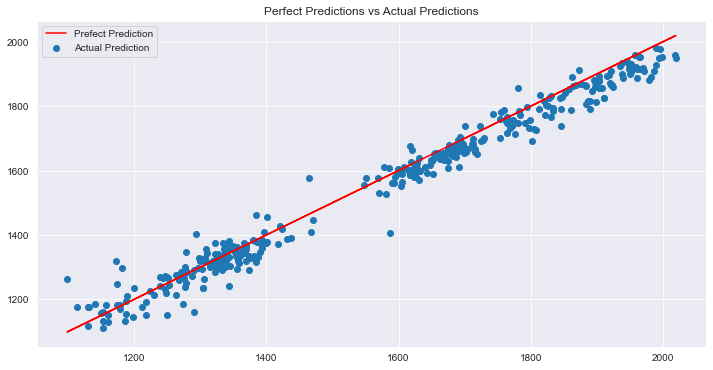

In [24]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions)
plt.plot(y_test, y_test, "-r")
plt.legend(["Prefect Prediction", "Actual Prediction"])
plt.title("Perfect Predictions vs Actual Predictions");

#### Training vs Validation vs Prediction

In [25]:
k_data = kotak_df.filter(["Adj Close"])

train = k_data[:training_data_len].copy()
valid = k_data[training_data_len:].copy()

valid["Predictions"] = predictions

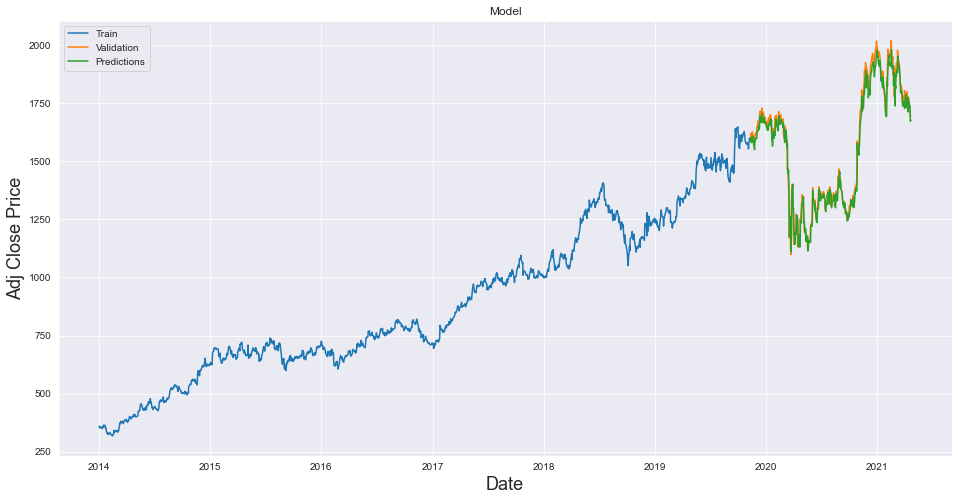

In [26]:
# Visualize the model
plt.figure(figsize=(16, 8))
plt.title("Model")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Adj Close Price", fontsize=18)
plt.plot(train["Adj Close"])
plt.plot(valid[["Adj Close", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="upper left");

## 💾Save the model

Exporting the Long Short-Term Memory (LSTM) model

In [27]:
from tensorflow.keras.models import load_model

In [28]:
# Save the model
model.save("model/lstm_model.h5")

In [30]:
# Load the saved model
loaded_model = load_model("model/lstm_model.h5")

# Get predictions
preds = loaded_model.predict(X_test)
preds = scaler.inverse_transform(preds)

# Root Mean Squared Error and Mean Absolute Error
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

Root Mean Squared Error: 42.310359049790364
Mean Absolute Error: 32.11264403616818
